In [136]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [137]:
face_cascade = cv2.CascadeClassifier('data/lbpcascade_frontalface.xml')

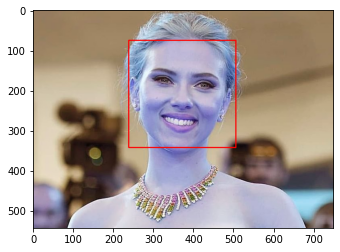

In [138]:
image = cv2.imread('example_imgs/scarlett.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Face detection
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
image_faces = image.copy()

# Puts a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(image_faces, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.imshow(image_faces)

In [142]:
# Normalizes image from 0 to 255 and make the values integer
def normalize(image):
    image_t = ((image - np.min(image)) * 255 / (np.max(image) - np.min(image))).astype(np.uint8)
    return image_t
    
# Applies convolution on a grayscaled image with given kernel with FFT
def convFFT(image, kernel):
    kernel_t = np.fft.fft2(kernel, s=(image.shape[:2]), axes=(0, 1))
    image_t = np.fft.fft2(image, axes=(0, 1))
    
    image_t = image_t * kernel_t[:, :]
    image_t = np.fft.ifft2(image_t, axes=(0, 1)).real
    
    return image_t
    
def gaussianFilter(image):
    t = np.linspace(-10, 10, 30)
    bump = np.exp(-0.1*t**2)
    bump /= np.trapz(bump)
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]

    image_t = convFFT(image, kernel)
    image_t = normalize(image_t)
    
    return image_t

def sobelFilter(image):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convFFT(image, Kx)
    Iy = convFFT(image, Ky)
    
    G = np.hypot(Ix, Iy)
    G = normalize(G)
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255

            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = img[i, j+1]
                r = img[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if (img[i,j] >= q) and (img[i,j] >= r):
                Z[i,j] = img[i,j]
            else:
                Z[i,j] = 0
    
    return Z

def double_threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [146]:
# Based on https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
def cannyEdgeDetection(image):
    image_f = gaussianFilter(image)
    image_f, theta = sobelFilter(image_f)
    image_f = non_max_suppression(image_f, theta)
    image_f, weak, strong = double_threshold(image_f)
    image_f = hysteresis(image_f, weak, strong)
    
    return image_f

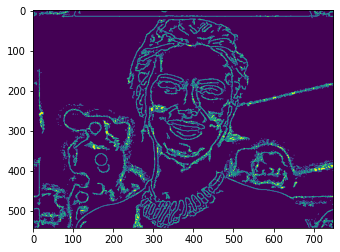

In [147]:
image_f = cannyEdgeDetection(gray)
plt.imshow(image_f)